In [ ]:
# Importing the required libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [37]:
'''Setting up the env'''

TRAIN_DIR = './TrainData'
TEST_DIR = './TestData'

IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
LR = 1e-3


'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'XrayImagesToCovidPrediction-{}-{}.model'.format(LR, '6conv-basic') 

data_dir = pathlib.Path(TRAIN_DIR)
test_dir = pathlib.Path(TEST_DIR)
print(data_dir)
train_image_count = len(list(data_dir.glob('*/*.png')))

test_image_count = len(list(test_dir.glob('*/*.*')))

print(train_image_count)
print(test_dir)
print(test_image_count)

TrainData
1560
TestData
338


In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 1560 files belonging to 2 classes.


In [39]:
print(train_ds.class_names)
class_names = train_ds.class_names

['negative', 'positive']


In [40]:
###
#train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#  data_dir,
#  seed=123,
 # image_size=(IMG_HEIGHT, IMG_WIDTH),
 # batch_size=BATCH_SIZE)
###

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 338 files belonging to 2 classes.


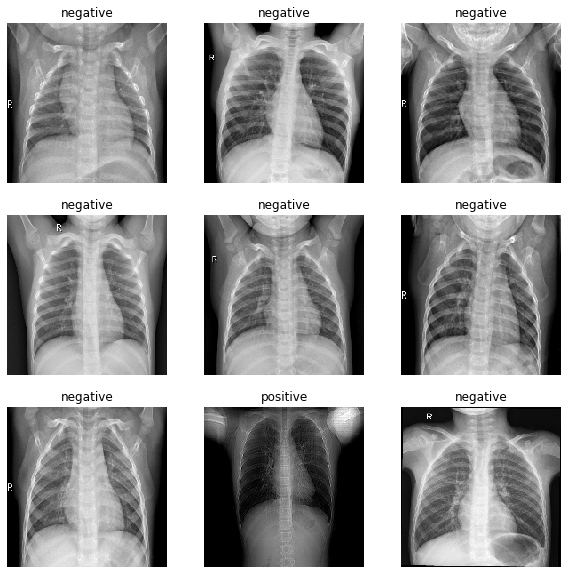

In [51]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [52]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [53]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [54]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [55]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [57]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [58]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
49/49 [==============================] - 29s 586ms/step - loss: 0.2573 - accuracy: 0.9295 - val_loss: 1.6717 - val_accuracy: 0.5533
Epoch 2/10
49/49 [==============================] - 25s 503ms/step - loss: 0.0510 - accuracy: 0.9814 - val_loss: 1.4199 - val_accuracy: 0.5592
Epoch 3/10
49/49 [==============================] - 24s 497ms/step - loss: 0.0326 - accuracy: 0.9885 - val_loss: 1.2636 - val_accuracy: 0.5828
Epoch 4/10
49/49 [==============================] - 24s 498ms/step - loss: 0.0242 - accuracy: 0.9929 - val_loss: 1.8061 - val_accuracy: 0.5828
Epoch 5/10
49/49 [==============================] - 24s 498ms/step - loss: 0.0215 - accuracy: 0.9917 - val_loss: 1.3066 - val_accuracy: 0.5680
Epoch 6/10
49/49 [==============================] - 24s 495ms/step - loss: 0.0255 - accuracy: 0.9897 - val_loss: 2.4238 - val_accuracy: 0.5503
Epoch 7/10
49/49 [==============================] - 24s 500ms/step - loss: 0.0091 - accuracy: 0.9955 - val_loss: 2.4393 - val_accuracy: 0.5473

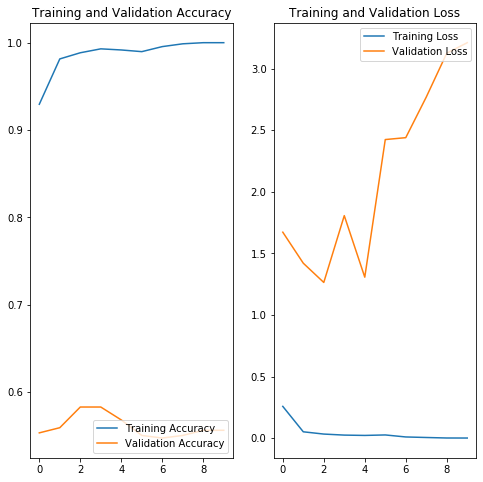

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

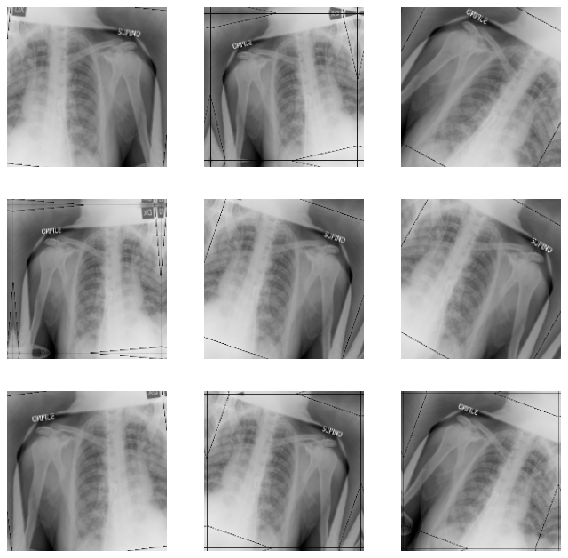

In [61]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [64]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
49/49 [==============================] - 23s 468ms/step - loss: 0.0232 - accuracy: 0.9936 - val_loss: 2.0236 - val_accuracy: 0.5621
Epoch 2/15
49/49 [==============================] - 24s 495ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 2.7788 - val_accuracy: 0.5533
Epoch 3/15
49/49 [==============================] - 25s 500ms/step - loss: 1.6829e-04 - accuracy: 1.0000 - val_loss: 3.2626 - val_accuracy: 0.5533
Epoch 4/15
49/49 [==============================] - 24s 497ms/step - loss: 8.6717e-05 - accuracy: 1.0000 - val_loss: 3.4299 - val_accuracy: 0.5562
Epoch 5/15
49/49 [==============================] - 25s 507ms/step - loss: 5.9219e-05 - accuracy: 1.0000 - val_loss: 3.6416 - val_accuracy: 0.5533
Epoch 6/15
49/49 [==============================] - 24s 498ms/step - loss: 4.5219e-05 - accuracy: 1.0000 - val_loss: 3.7163 - val_accuracy: 0.5562
Epoch 7/15
49/49 [==============================] - 24s 498ms/step - loss: 3.5637e-05 - accuracy: 1.0000 - val_loss: 3.8379 - 

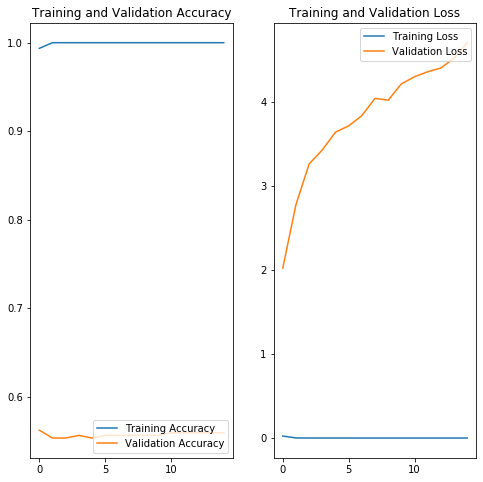

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [66]:
#test_dir = pathlib.Path(TEST_DIR)
test_neg = './TestData/CR.1.2.840.113564.192168196.2020031913094890017.1203801020003.png'
img = keras.preprocessing.image.load_img(
    test_neg
    , target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to positive with a 99.98 percent confidence.


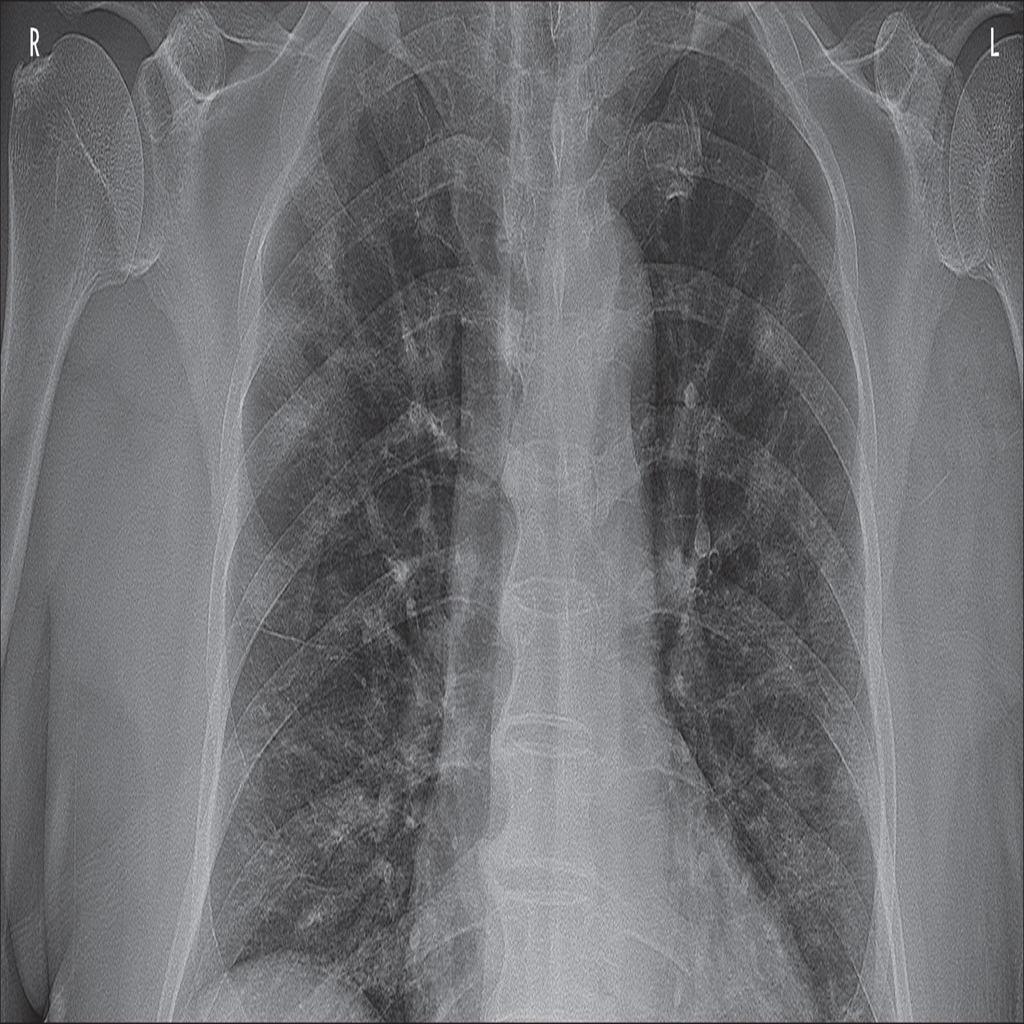

In [67]:
pos = list(data_dir.glob('positive/*'))
PIL.Image.open(str(pos[0]))

In [68]:
test_neg = './TestData/CR.1.2.840.113564.1722810170.202003211940047348.1003000225002.png'
img = keras.preprocessing.image.load_img(
    test_neg
    , target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to positive with a 100.00 percent confidence.
